# 1. Cài đặt thư viện

In [1]:
!pip install datasets

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 480.6/480.6 kB 14.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 3.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.3/179.3 kB 12.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 5.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 7.6 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2024.10.0
    Uninstalling fsspec-2024.10.0:
      Successfully uninstalled fsspec-2024.10.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2024.10.0 requires fsspec==2024.10.0, but you have fsspec 2024.9.0 which is incompatible.


In [2]:
!pip install sacrebleu

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 51.8/51.8 kB 3.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 104.0/104.0 kB 7.7 MB/s eta 0:00:00


In [3]:
!pip install evaluate


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.0/84.0 kB 4.2 MB/s eta 0:00:00


In [4]:
from datasets import load_dataset, Dataset
import re
import matplotlib.pyplot as plt
from sacrebleu import corpus_bleu
# from transformers import AutoTokenizer
from transformers import MBartTokenizer
import evaluate
# from datasets import load_metric


# 2. Load Dataset

In [5]:
ds = load_dataset("nhuvo/MedEV")

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md:   0%|          | 0.00/1.96k [00:00<?, ?B/s]

train.en.txt:   0%|          | 0.00/48.6M [00:00<?, ?B/s]

train.vi.txt:   0%|          | 0.00/61.9M [00:00<?, ?B/s]

val.en.new.txt:   0%|          | 0.00/1.30M [00:00<?, ?B/s]

val.vi.new.txt:   0%|          | 0.00/1.66M [00:00<?, ?B/s]

test.en.new.txt:   0%|          | 0.00/1.28M [00:00<?, ?B/s]

test.vi.new.txt:   0%|          | 0.00/1.64M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/681794 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/17878 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/17920 [00:00<?, ? examples/s]

# 3. Kiểm tra tổng quan dataset

In [6]:
print(ds)  # Xem tổng quan về tập dữ liệuprint(ds)  # Xem tổng quan về tập dữ liệu

DatasetDict({
    train: Dataset({
        features: ['text'],
        num_rows: 681794
    })
    validation: Dataset({
        features: ['text'],
        num_rows: 17878
    })
    test: Dataset({
        features: ['text'],
        num_rows: 17920
    })
})


# 4. Chia lại Source và Target

In [7]:
def split_source_target(dataset):
    """
    Tách cột `text` thành `source` và `target` dựa vào số lượng dòng.
    """
    num_rows = len(dataset)
    mid_index = num_rows // 2  # Chia đôi dataset

    # Chia dữ liệu thành hai phần
    source_data = dataset.select(range(0, mid_index))  # Nửa trên: source
    target_data = dataset.select(range(mid_index, num_rows))  # Nửa dưới: target

    # Tạo dataset mới với cột `source` và `target`
    new_dataset = Dataset.from_dict({
        "source": source_data["text"],
        "target": target_data["text"]
    })
    return new_dataset

# Áp dụng cho các tập train, validation, test
ds['train'] = split_source_target(ds['train'])
ds['validation'] = split_source_target(ds['validation'])
ds['test'] = split_source_target(ds['test'])

# Kiểm tra kết quả
print(ds['train'][0])  # Xem cặp source-target đầu tiên
print(ds['train'][-1])  # Xem cặp source-target cuối cùng


{'source': 'To evaluate clinical, subclinical symptoms of patients with otitis media with effusion and V.a at otorhinolaryngology department – Thai Nguyen national hospital', 'target': 'Nghiên cứu đặc điểm lâm sàng, cận lâm sàng bệnh nhân viêm tai ứ dịch trên viêm V.A tại Khoa Tai mũi họng - Bệnh viện Trung ương Thái Nguyên'}
{'source': 'When you begin catastrophising in the lead-up to an attack, write down the thoughts that are worrying you, then throw the page away.', 'target': 'Khi bạn bắt đầu trầm trọng hoá vấn đề dẫn đến cơn hoảng loạn, hãy viết ra những suy nghĩ khiến bạn lo lắng, sau đó vứt bỏ trang giấy đi.'}


In [8]:
print(f"Train size: {len(ds['train'])}")
print(f"Validation size: {len(ds['validation'])}")
print(f"Test size: {len(ds['test'])}")

Train size: 340897
Validation size: 8939
Test size: 8960


In [9]:
ds['validation']

Dataset({
    features: ['source', 'target'],
    num_rows: 8939
})

In [10]:
print(ds)

DatasetDict({
    train: Dataset({
        features: ['source', 'target'],
        num_rows: 340897
    })
    validation: Dataset({
        features: ['source', 'target'],
        num_rows: 8939
    })
    test: Dataset({
        features: ['source', 'target'],
        num_rows: 8960
    })
})


# 5. PRE-PROCESSING

## 5.1. Cleaning (Hàm này không bỏ nha, mình có nhằm lẫn xíu chỗ này á (^_^))

In [11]:
# Step 1: Cleaning the dataset
def clean_text(text):
    import re
    text = text.strip()  # Giữ nguyên chữ hoa và chữ thường
    text = re.sub(r"[\uf0b1\uf063\uf05d\xad\uf062\uf76a\uf0b0\uf03c\uf02d\uf067\ufeff\uf0ae\uf0b3\uf044\uf0a3\uf020\uf061\uf0b4\uf06d\uf026\uf05b\uf0a2\uf0d2\x02\u200e\u200b\ufeff\uf067\uf02d]", "", text)
    text = re.sub(r"\s+", " ", text)  # Loại bỏ khoảng trắng thừa
    return text

# Áp dụng cleaning cho source và target
ds['train'] = ds['train'].map(lambda x: {'source': clean_text(x['source']), 'target': clean_text(x['target'])})
ds['validation'] = ds['validation'].map(lambda x: {'source': clean_text(x['source']), 'target': clean_text(x['target'])})
ds['test'] = ds['test'].map(lambda x: {'source': clean_text(x['source']), 'target': clean_text(x['target'])})


Map:   0%|          | 0/340897 [00:00<?, ? examples/s]

Map:   0%|          | 0/8939 [00:00<?, ? examples/s]

Map:   0%|          | 0/8960 [00:00<?, ? examples/s]

In [12]:
print(ds['train'][0])  # Xem cặp source-target đầu tiên
print(ds['train'][-1])  # Xem cặp source-target cuối cùng

{'source': 'To evaluate clinical, subclinical symptoms of patients with otitis media with effusion and V.a at otorhinolaryngology department – Thai Nguyen national hospital', 'target': 'Nghiên cứu đặc điểm lâm sàng, cận lâm sàng bệnh nhân viêm tai ứ dịch trên viêm V.A tại Khoa Tai mũi họng - Bệnh viện Trung ương Thái Nguyên'}
{'source': 'When you begin catastrophising in the lead-up to an attack, write down the thoughts that are worrying you, then throw the page away.', 'target': 'Khi bạn bắt đầu trầm trọng hoá vấn đề dẫn đến cơn hoảng loạn, hãy viết ra những suy nghĩ khiến bạn lo lắng, sau đó vứt bỏ trang giấy đi.'}


## 5.2 Tokenization

### 5.2.1. Chạy thử tokenization với 1 câu

#### 5.2.1.1. Dùng WordPiece Tokenizer được huấn luyện trước từ model 'bert-base-uncased'

In [13]:
from transformers import BertTokenizer

# Load the pre-trained BERT tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

# Encode a sentence
encoding = tokenizer.encode_plus(
    "Tokenization is crucial for NLP tasks.",
    add_special_tokens=True,  # Adds [CLS] and [SEP] tokens
    return_tensors='pt'       # Returns PyTorch tensors
)

# Print the input IDs
print("Input IDs:", encoding['input_ids'])

# Print the tokens
tokens = tokenizer.convert_ids_to_tokens(encoding['input_ids'][0])
print("Tokens:", tokens)

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

Input IDs: tensor([[  101, 19204,  3989,  2003, 10232,  2005, 17953,  2361,  8518,  1012,
           102]])
Tokens: ['[CLS]', 'token', '##ization', 'is', 'crucial', 'for', 'nl', '##p', 'tasks', '.', '[SEP]']


#### 5.2.1.2. Dùng model "facebook/mbart-large-50"

In [14]:
# Tải tokenizer (ví dụ: mBART hoặc T5)
tokenizer = MBartTokenizer.from_pretrained("facebook/mbart-large-50")


# Encode a sentence
encoding = tokenizer.encode_plus(
    "Tokenization is crucial for NLP tasks.",
    add_special_tokens=True,  # Adds [CLS] and [SEP] tokens
    return_tensors='pt'       # Returns PyTorch tensors
)

# Print the input IDs
print("Input IDs:", encoding['input_ids'])

# Print the tokens
tokens = tokenizer.convert_ids_to_tokens(encoding['input_ids'][0])
print("Tokens:", tokens)

tokenizer_config.json:   0%|          | 0.00/531 [00:00<?, ?B/s]

sentencepiece.bpe.model:   0%|          | 0.00/5.07M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/649 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.42k [00:00<?, ?B/s]

The tokenizer class you load from this checkpoint is not the same type as the class this function is called from. It may result in unexpected tokenization. 
The tokenizer class you load from this checkpoint is 'MBart50Tokenizer'. 
The class this function is called from is 'MBartTokenizer'.


Input IDs: tensor([[   717,   1098,  47691,     83, 106157,    100,    541,  37352,  66211,
              7,      5,      2, 250004]])
Tokens: ['▁To', 'ken', 'ization', '▁is', '▁crucial', '▁for', '▁N', 'LP', '▁task', 's', '.', '</s>', 'en_XX']


#### 5.2.1.3. Dùng model "google-bert/bert-base-multilingual-cased" (Nên dùng cái này hơn 2 PP kia)

In [15]:
from transformers import AutoTokenizer, AutoModelForMaskedLM
# Tải tokenizer (ví dụ: mBART hoặc T5)
tokenizer = AutoTokenizer.from_pretrained("google-bert/bert-base-multilingual-cased")


# Encode a sentence
encoding = tokenizer.encode_plus(
    "Tokenization is crucial for NLP tasks.",
    add_special_tokens=True,  # Adds [CLS] and [SEP] tokens
    return_tensors='pt'       # Returns PyTorch tensors
)

# Print the input IDs
print("Input IDs:", encoding['input_ids'])

# Print the tokens
tokens = tokenizer.convert_ids_to_tokens(encoding['input_ids'][0])
print("Tokens:", tokens)

tokenizer_config.json:   0%|          | 0.00/49.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/625 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/996k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.96M [00:00<?, ?B/s]

Input IDs: tensor([[  101, 11469, 11062, 19980, 10124, 63113, 10142, 81130, 11127, 72068,
           119,   102]])
Tokens: ['[CLS]', 'To', '##ken', '##ization', 'is', 'crucial', 'for', 'NL', '##P', 'tasks', '.', '[SEP]']


### 5.2.2. Áp dụng lên data của mình

#### 5.2.2.1. Phương pháp tokenizer dùng "bert-base-uncased"

In [16]:
from transformers import BertTokenizer
from datasets import DatasetDict  # Để phù hợp với cấu trúc dataset của bạn

# Load the pre-trained BERT tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

# Tokenize function để áp dụng lên toàn bộ dataset
def tokenize_function(examples):
    # Tokenize cả source và target
    source_encodings = tokenizer(
        examples['source'],
        add_special_tokens=True,  # Thêm các token [CLS] và [SEP]
        truncation=True,          # Cắt ngắn nếu quá dài
        padding="max_length",     # Padding đến độ dài tối đa
        max_length=128,           # Giới hạn độ dài (tùy chọn)
        return_tensors="pt"       # Trả về tensors PyTorch
    )

    target_encodings = tokenizer(
        examples['target'],
        add_special_tokens=True,
        truncation=True,
        padding="max_length",
        max_length=128,
        return_tensors="pt"
    )

    return {
        "input_ids_source": source_encodings['input_ids'][0].tolist(),
        "tokens_source": tokenizer.convert_ids_to_tokens(source_encodings['input_ids'][0]),
        "input_ids_target": target_encodings['input_ids'][0].tolist(),
        "tokens_target": tokenizer.convert_ids_to_tokens(target_encodings['input_ids'][0])
    }

# Tokenize toàn bộ dataset
tokenized_datasets = ds.map(tokenize_function, batched=False)

# Xem mẫu đầu tiên trong tập train sau khi tokenize
print("Tokenized dataset example:", tokenized_datasets['train'][0])


Map:   0%|          | 0/340897 [00:00<?, ? examples/s]

Map:   0%|          | 0/8939 [00:00<?, ? examples/s]

Map:   0%|          | 0/8960 [00:00<?, ? examples/s]

Tokenized dataset example: {'source': 'To evaluate clinical, subclinical symptoms of patients with otitis media with effusion and V.a at otorhinolaryngology department – Thai Nguyen national hospital', 'target': 'Nghiên cứu đặc điểm lâm sàng, cận lâm sàng bệnh nhân viêm tai ứ dịch trên viêm V.A tại Khoa Tai mũi họng - Bệnh viện Trung ương Thái Nguyên', 'input_ids_source': [101, 2000, 16157, 6612, 1010, 4942, 20464, 5498, 9289, 8030, 1997, 5022, 2007, 27178, 13706, 2865, 2007, 1041, 4246, 14499, 1998, 1058, 1012, 1037, 2012, 27178, 2953, 10606, 19478, 6038, 24141, 15707, 2533, 1516, 7273, 16577, 2120, 2902, 102, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 'tokens_source': ['[CLS]', 'to', 'evaluate', 'clinical', ',', 'sub', '##cl', '##ini', '##cal', 'symptoms', 'of', 

In [17]:
# Xem mẫu đầu tiên trong tập train sau khi tokenize
print("Tokenized dataset example:", tokenized_datasets['train'][0])

Tokenized dataset example: {'source': 'To evaluate clinical, subclinical symptoms of patients with otitis media with effusion and V.a at otorhinolaryngology department – Thai Nguyen national hospital', 'target': 'Nghiên cứu đặc điểm lâm sàng, cận lâm sàng bệnh nhân viêm tai ứ dịch trên viêm V.A tại Khoa Tai mũi họng - Bệnh viện Trung ương Thái Nguyên', 'input_ids_source': [101, 2000, 16157, 6612, 1010, 4942, 20464, 5498, 9289, 8030, 1997, 5022, 2007, 27178, 13706, 2865, 2007, 1041, 4246, 14499, 1998, 1058, 1012, 1037, 2012, 27178, 2953, 10606, 19478, 6038, 24141, 15707, 2533, 1516, 7273, 16577, 2120, 2902, 102, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 'tokens_source': ['[CLS]', 'to', 'evaluate', 'clinical', ',', 'sub', '##cl', '##ini', '##cal', 'symptoms', 'of', 

#### 5.2.2.2. Phương pháp tokenizer dùng "facebook/mbart-large-50"

In [18]:
from transformers import BertTokenizer
from datasets import DatasetDict  # Để phù hợp với cấu trúc dataset của bạn

# Load the pre-trained BERT tokenizer
tokenizer = MBartTokenizer.from_pretrained("facebook/mbart-large-50")

# Tokenize function để áp dụng lên toàn bộ dataset
def tokenize_function(examples):
    # Tokenize cả source và target
    source_encodings = tokenizer(
        examples['source'],
        add_special_tokens=True,  # Thêm các token [CLS] và [SEP]
        truncation=True,          # Cắt ngắn nếu quá dài
        padding="max_length",     # Padding đến độ dài tối đa
        max_length=128,           # Giới hạn độ dài (tùy chọn)
        return_tensors="pt"       # Trả về tensors PyTorch
    )

    target_encodings = tokenizer(
        examples['target'],
        add_special_tokens=True,
        truncation=True,
        padding="max_length",
        max_length=128,
        return_tensors="pt"
    )

    return {
        "input_ids_source": source_encodings['input_ids'][0].tolist(),
        "tokens_source": tokenizer.convert_ids_to_tokens(source_encodings['input_ids'][0]),
        "input_ids_target": target_encodings['input_ids'][0].tolist(),
        "tokens_target": tokenizer.convert_ids_to_tokens(target_encodings['input_ids'][0])
    }

# Tokenize toàn bộ dataset
tokenized_datasets = ds.map(tokenize_function, batched=False)

# Xem mẫu đầu tiên trong tập train sau khi tokenize
print("Tokenized dataset example:", tokenized_datasets['train'][0])


The tokenizer class you load from this checkpoint is not the same type as the class this function is called from. It may result in unexpected tokenization. 
The tokenizer class you load from this checkpoint is 'MBart50Tokenizer'. 
The class this function is called from is 'MBartTokenizer'.


Map:   0%|          | 0/340897 [00:00<?, ? examples/s]

Map:   0%|          | 0/8939 [00:00<?, ? examples/s]

Map:   0%|          | 0/8960 [00:00<?, ? examples/s]

Tokenized dataset example: {'source': 'To evaluate clinical, subclinical symptoms of patients with otitis media with effusion and V.a at otorhinolaryngology department – Thai Nguyen national hospital', 'target': 'Nghiên cứu đặc điểm lâm sàng, cận lâm sàng bệnh nhân viêm tai ứ dịch trên viêm V.A tại Khoa Tai mũi họng - Bệnh viện Trung ương Thái Nguyên', 'input_ids_source': [717, 151575, 13, 56465, 289, 4, 1614, 92768, 21533, 153698, 111, 60264, 678, 36, 31821, 7, 2450, 678, 9129, 92105, 136, 310, 5, 11, 99, 36, 1290, 4505, 929, 6635, 449, 25443, 130625, 46, 13322, 214133, 15889, 17986, 2, 250004, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], 'tokens_source': ['▁To', '▁evaluat', 'e', '▁clinic', 'al', ',', '▁sub', 'clin', 'ical', '▁symptoms', '▁of', '▁patients', '▁with', '▁

In [19]:
print("Tokenized dataset example:", tokenized_datasets['train'][0])

Tokenized dataset example: {'source': 'To evaluate clinical, subclinical symptoms of patients with otitis media with effusion and V.a at otorhinolaryngology department – Thai Nguyen national hospital', 'target': 'Nghiên cứu đặc điểm lâm sàng, cận lâm sàng bệnh nhân viêm tai ứ dịch trên viêm V.A tại Khoa Tai mũi họng - Bệnh viện Trung ương Thái Nguyên', 'input_ids_source': [717, 151575, 13, 56465, 289, 4, 1614, 92768, 21533, 153698, 111, 60264, 678, 36, 31821, 7, 2450, 678, 9129, 92105, 136, 310, 5, 11, 99, 36, 1290, 4505, 929, 6635, 449, 25443, 130625, 46, 13322, 214133, 15889, 17986, 2, 250004, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], 'tokens_source': ['▁To', '▁evaluat', 'e', '▁clinic', 'al', ',', '▁sub', 'clin', 'ical', '▁symptoms', '▁of', '▁patients', '▁with', '▁

#### 5.2.2.3. Phương pháp tokenizer dùng "google-bert/bert-base-multilingual-cased" (Nên dùng cái này hơn 2 PP kia)

In [20]:
from transformers import BertTokenizer
from datasets import DatasetDict  # Để phù hợp với cấu trúc dataset của bạn
from transformers import AutoTokenizer, AutoModelForMaskedLM

# Tải tokenizer (ví dụ: mBART hoặc T5)
tokenizer = AutoTokenizer.from_pretrained("google-bert/bert-base-multilingual-cased")


# Tokenize function để áp dụng lên toàn bộ dataset
def tokenize_function(examples):
    # Tokenize cả source và target
    source_encodings = tokenizer(
        examples['source'],
        add_special_tokens=True,  # Thêm các token [CLS] và [SEP]
        truncation=True,          # Cắt ngắn nếu quá dài
        padding="max_length",     # Padding đến độ dài tối đa
        max_length=128,           # Giới hạn độ dài (tùy chọn)
        return_tensors="pt"       # Trả về tensors PyTorch
    )

    target_encodings = tokenizer(
        examples['target'],
        add_special_tokens=True,
        truncation=True,
        padding="max_length",
        max_length=128,
        return_tensors="pt"
    )

    return {
        "input_ids_source": source_encodings['input_ids'][0].tolist(),
        "tokens_source": tokenizer.convert_ids_to_tokens(source_encodings['input_ids'][0]),
        "input_ids_target": target_encodings['input_ids'][0].tolist(),
        "tokens_target": tokenizer.convert_ids_to_tokens(target_encodings['input_ids'][0])
    }

# Tokenize toàn bộ dataset
tokenized_datasets = ds.map(tokenize_function, batched=False)

# Xem mẫu đầu tiên trong tập train sau khi tokenize
print("Tokenized dataset example:", tokenized_datasets['train'][0])


Map:   0%|          | 0/340897 [00:00<?, ? examples/s]

Map:   0%|          | 0/8939 [00:00<?, ? examples/s]

Map:   0%|          | 0/8960 [00:00<?, ? examples/s]

Tokenized dataset example: {'source': 'To evaluate clinical, subclinical symptoms of patients with otitis media with effusion and V.a at otorhinolaryngology department – Thai Nguyen national hospital', 'target': 'Nghiên cứu đặc điểm lâm sàng, cận lâm sàng bệnh nhân viêm tai ứ dịch trên viêm V.A tại Khoa Tai mũi họng - Bệnh viện Trung ương Thái Nguyên', 'input_ids_source': [101, 11469, 103730, 107114, 10112, 43463, 117, 13987, 86257, 17616, 62319, 10108, 25965, 10169, 60818, 36967, 12518, 10169, 56331, 55729, 11046, 10111, 159, 119, 169, 10160, 60818, 10667, 107485, 10774, 13379, 31002, 37652, 21079, 100, 26207, 91961, 11844, 18141, 102, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 'tokens_source': ['[CLS]', 'To', 'eva', '##luat', '##e', 'clinical', ',', 'sub', '##clin',

In [21]:
print("Tokenized dataset example:", tokenized_datasets['train'][0])

Tokenized dataset example: {'source': 'To evaluate clinical, subclinical symptoms of patients with otitis media with effusion and V.a at otorhinolaryngology department – Thai Nguyen national hospital', 'target': 'Nghiên cứu đặc điểm lâm sàng, cận lâm sàng bệnh nhân viêm tai ứ dịch trên viêm V.A tại Khoa Tai mũi họng - Bệnh viện Trung ương Thái Nguyên', 'input_ids_source': [101, 11469, 103730, 107114, 10112, 43463, 117, 13987, 86257, 17616, 62319, 10108, 25965, 10169, 60818, 36967, 12518, 10169, 56331, 55729, 11046, 10111, 159, 119, 169, 10160, 60818, 10667, 107485, 10774, 13379, 31002, 37652, 21079, 100, 26207, 91961, 11844, 18141, 102, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 'tokens_source': ['[CLS]', 'To', 'eva', '##luat', '##e', 'clinical', ',', 'sub', '##clin',

# 6. Xem cấu trúc của dataset sau khi thực hiện tokenizer

In [22]:
print(tokenized_datasets)

DatasetDict({
    train: Dataset({
        features: ['source', 'target', 'input_ids_source', 'tokens_source', 'input_ids_target', 'tokens_target'],
        num_rows: 340897
    })
    validation: Dataset({
        features: ['source', 'target', 'input_ids_source', 'tokens_source', 'input_ids_target', 'tokens_target'],
        num_rows: 8939
    })
    test: Dataset({
        features: ['source', 'target', 'input_ids_source', 'tokens_source', 'input_ids_target', 'tokens_target'],
        num_rows: 8960
    })
})


#Tính toán metric cho pretrained model (Bỏ)

In [ ]:
# # Dự đoán từ input_ids, chuyển về dạng văn bản
# predictions = tokenizer.batch_decode(tokenized_datasets['validation']['input_ids'], skip_special_tokens=True)

# # Hoặc sử dụng data['source'] nếu bạn muốn so sánh với dữ liệu gốc
# references = tokenized_datasets['validation']['source']

# # Tính toán BLEU
# metric = evaluate.load("bleu")
# results = metric.compute(predictions=predictions, references=references)

# print(results)


{'bleu': 0.40276090705025785, 'precisions': [0.41913727108752896, 0.4085976324188922, 0.39767857620437747, 0.3863713527629092], 'brevity_penalty': 1.0, 'length_ratio': 2.3855708557984974, 'translation_length': 503959, 'reference_length': 211253}


# DATA ANALYSIS (Bỏ)

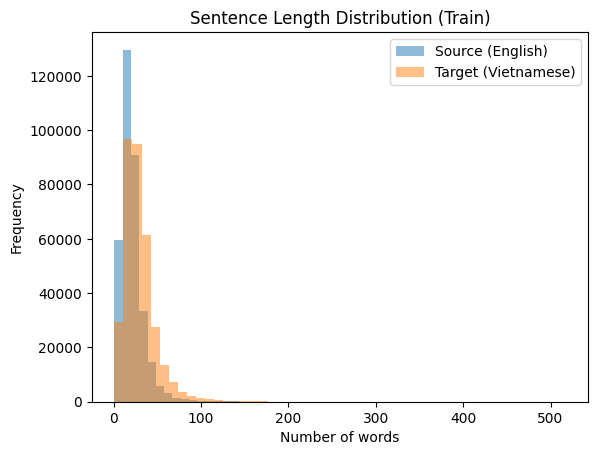

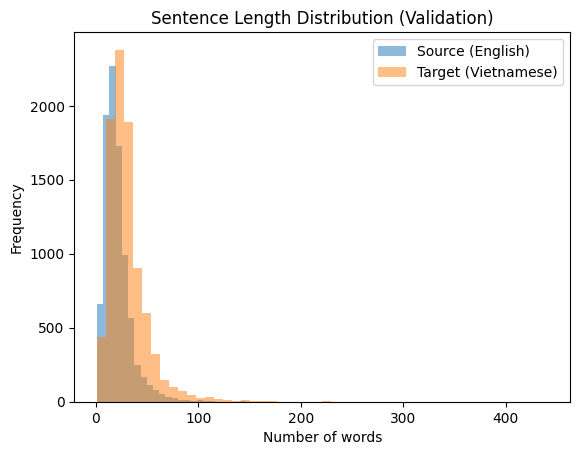

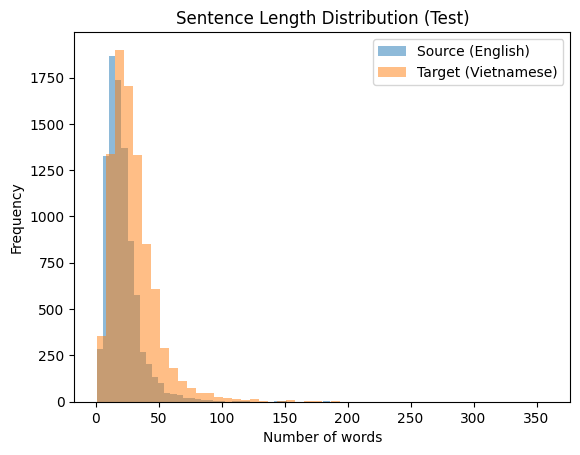

In [ ]:
# Analyze sentence lengths
def analyze_sentence_lengths(dataset, split_name):
    lengths_source = [len(text.split()) for text in dataset['source']]
    lengths_target = [len(text.split()) for text in dataset['target']]

    plt.hist(lengths_source, bins=50, alpha=0.5, label="Source (English)")
    plt.hist(lengths_target, bins=50, alpha=0.5, label="Target (Vietnamese)")
    plt.title(f"Sentence Length Distribution ({split_name})")
    plt.xlabel("Number of words")
    plt.ylabel("Frequency")
    plt.legend()
    plt.show()

# Analyze train, validation, and test
analyze_sentence_lengths(ds['train'], "Train")
analyze_sentence_lengths(ds['validation'], "Validation")
analyze_sentence_lengths(ds['test'], "Test")